In [18]:
# Load all necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

In [19]:
class ObjectiveFunction:
    def __init__(self, method):
        self.method = method
    
    def get_loss(self, y, y_hat):
        if self.method == "cel":
            return self.cross_entropy_loss(y, y_hat)
        elif self.method == "mse":
            return self.mean_square_error(y, y_hat)
    
    def get_derivative(self, y, y_hat):
        if self.method == "cel":
            return self.cross_entropy_loss_derivative(y, y_hat)
        elif self.method == "mse":
            return self.mean_square_error_derivative(y, y_hat)
    
    def mean_square_error(self, y, y_hat):
        return np.sum((y - y_hat) ** 2) / 2
    
    def mean_square_error_derivative(self, y, y_hat):
        return y_hat - y
    
    def cross_entropy_loss(self, y, y_hat):
        return -np.sum(y * np.log(y_hat))
    
    def cross_entropy_loss_derivative(self, y, y_hat):
        return -y/y_hat

In [20]:
class NeuralLayer: 
    def __init__(self, index, n_input, n_neurons, function=None, weights=None, bias=None, method="random"):
        self.index = index
        self.function = function if function is not None else 'sigmoid'
        self.weights = weights if weights is not None else self.initialize_weights(method, n_input, n_neurons)
        self.bias = bias if bias is not None else np.random.randn(n_neurons)
        self.activation = None
        
        self.error = None
        self.delta = None
        
        self.d_weights = None
        self.d_bias = None

    def initialize_weights(self, method, n_input, n_neurons):
        if method == "xavier":
            limit = np.sqrt(2 / (n_input + n_neurons))
            return np.random.randn(n_input, n_neurons) * limit
        return np.random.randn(n_input, n_neurons)

    def activate(self, x):
        z = np.dot(x, self.weights) + self.bias
        self.activation = self._apply_activation(z)
        return self.activation

    def _apply_activation(self, r):
        if self.function == 'sigmoid':
            return 1 / (1 + np.exp(-r))
        elif self.function == 'tanh':
            return np.tanh(r)
        elif self.function == 'relu':
            return np.maximum(0, r)
        elif self.function == 'softmax':
            max_r = np.max(r, axis=1)
            max_r = max_r.reshape(max_r.shape[0], 1)
            exp_r = np.exp(r - max_r)
            return exp_r / np.sum(exp_r, axis=1).reshape(exp_r.shape[0], 1)
        return r

    def apply_activation_derivative(self, z):
        if self.function == 'sigmoid':
            return z * (1 - z)
        elif self.function == 'tanh':
            return (z - z**2)
        elif self.function == 'relu':
            return np.where(z > 0, 1, 0)
        elif self.function == 'softmax':
            return np.diag(z) - np.outer(z, z)
        return np.ones(z.shape)
    
    def __str__(self):
        return f'Neural Layer: {self.index}, {self.weights.shape} , {self.function}'

In [72]:
class NeuralNetwork:
    def __init__(self, config):
        def get_value(key, default):
            return config[key] if key in config else default
        
        self.layers = []
        
        self.criterion = get_value('criterion', 'cel')
        self.weight_initialization = get_value('weight_initialization', 'random')
        
        self.c = ObjectiveFunction(method=self.criterion)
        
        self.add_layers(config['input_size'], 
                         config['hidden_layers'], 
                         config['output_size'], 
                         config['neurons'],
                         config['activation'],
                         config['output_activation']
                        )
    
    def forward(self, x):
        for layer in self.layers:
            x = layer.activate(x)
        return x

    def backward(self, x, y, y_hat):
        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]
            if layer == self.layers[-1]:
                layer.error = self.c.get_derivative(y, y_hat)
                output_derivative_matrix = []
                for i in range(y_hat.shape[0]):
                    output_derivative_matrix.append(np.matmul(
                        self.c.get_derivative(y[i], y_hat[i]), 
                        layer.apply_activation_derivative(y_hat[i])
                    ))
                layer.delta = np.array(output_derivative_matrix)
            else:
                next_layer = self.layers[i + 1]
                layer.error = np.matmul(next_layer.delta, next_layer.weights.T)
                layer.delta = layer.error * layer.apply_activation_derivative(layer.activation)
        
        
        for i in range(len(self.layers)):
            layer = self.layers[i]
            activation = np.atleast_2d(x if i == 0 else self.layers[i - 1].activation)
            layer.d_weights = np.matmul(activation.T, layer.delta)/y.shape[0]
            layer.d_bias = np.sum(layer.delta, axis=0)/y.shape[0]
    
    def add_layers(self, input_size, hidden_layers, output_size, neurons, activation, output_activation):
        for i in range(0, hidden_layers+1):
            n_input = input_size if i==0 else neurons
            n_neurons = output_size if i==hidden_layers else neurons
            self.layers.append(NeuralLayer(
                index=i+1,
                n_input=n_input,
                n_neurons=n_neurons,
                function= output_activation if i==hidden_layers else activation,
                method=self.weight_initialization
                )
            )

In [73]:
class Optimizer:
    def __init__(self, nn:NeuralNetwork, config=None):
        # Initialize parameters
        self.nn, self.lr, self.optimizer = nn, config['learning_rate'], config['optimizer']
        self.beta, self.epsilon, self.beta1, self.beta2= config['beta'], config['epsilon'], config['beta1'], config['beta2']
        self.timestep = 0
        self.decay = config['decay']

    def step(self):
        if(self.optimizer == "sgd"):
            self.sgd()
    
    def sgd(self):
        for layer in self.nn.layers:
            layer.weights -= self.lr * (layer.d_weights + self.decay*layer.weights)
            layer.bias -= self.lr * (layer.d_bias + self.decay*layer.bias)

In [74]:
# Load Input Data
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Flatten the images
train_images = train_images.reshape(train_images.shape[0], 784) / 255
X_test = test_images.reshape(test_images.shape[0], 784) / 255

# Encode the labels
train_labels = np.eye(10)[train_labels]
Y_test = np.eye(10)[test_labels]

# Prepare data for training and validation
X_train, X_val, Y_train, Y_val = train_test_split(train_images, train_labels, test_size=0.1, shuffle=True, random_state=27)

In [75]:
def train(config):
    train_loss_hist = []
    train_accuracy_hist = []
    val_loss_hist = []
    val_accuracy_hist = []
    
    nn = NeuralNetwork(config)
    optimizer = Optimizer(nn=nn, config=config)
    
    batch_size = config['batch_size']
    criterion = ObjectiveFunction(method = config['criterion'])
    
    for epoch in range(config['epochs']):
        for batch in range(0, X_train.shape[0], batch_size):
            # Get the batch of data
            X_batch = X_train[batch:batch+batch_size]
            Y_batch = Y_train[batch:batch+batch_size]

            Y_hat_batch = nn.forward(X_batch)
            nn.backward(X_batch, Y_batch, Y_hat_batch)
            optimizer.step()
        
        optimizer.timestep += 1
        
        # Training
        Y_hat_train = nn.forward(X_train)
        train_loss = criterion.get_loss(Y_train, Y_hat_train)
        train_accuracy = np.sum(np.argmax(Y_hat_train, axis=1) == np.argmax(Y_train, axis=1)) / Y_train.shape[0]
            
        # Validation
        Y_hat_val = nn.forward(X_val)
        val_loss = criterion.get_loss(Y_val, Y_hat_val)
        val_accuracy = np.sum(np.argmax(Y_hat_val, axis=1) == np.argmax(Y_val, axis=1)) / Y_val.shape[0]
        
        print("Epoch {} Train Loss {} Train Accuracy {} Val Loss {} Val Accuracy {}".format(epoch, train_loss, train_accuracy, val_loss, val_accuracy))
   
        train_loss_hist.append(train_loss)
        train_accuracy_hist.append(train_accuracy)
        val_loss_hist.append(val_loss)
        val_accuracy_hist.append(val_accuracy)
    
    return nn, train_loss_hist, train_accuracy_hist, val_loss_hist, val_accuracy_hist

In [77]:
network_config = {
    'input_size': 784,
    'output_size': 10,
    'hidden_layers': 1,
    'neurons':256,
    'activation':'sigmoid',
    'output_activation':'softmax',
    'learning_rate': 0.005,
    'beta': 0.8,
    'beta1': 0.9,
    'beta2':0.9999,
    'epsilon': 1e-8,
    'epochs': 10,
    'optimizer': "sgd",
    'criterion': "cel",
    'decay': 0.0005,
    'weight_initialization': "random",
    'batch_size': 64,
}
        
nn, tl, ta, vl, va = train(network_config)

Epoch 0 Train Loss 148538.96836218005 Train Accuracy 0.4615 Val Loss 16356.60250680556 Val Accuracy 0.46166666666666667
Epoch 1 Train Loss 106542.82064495323 Train Accuracy 0.5813148148148148 Val Loss 11917.44363637784 Val Accuracy 0.5755
Epoch 2 Train Loss 90799.20199302644 Train Accuracy 0.6322592592592593 Val Loss 10260.23921369519 Val Accuracy 0.6258333333333334
Epoch 3 Train Loss 81767.8684759237 Train Accuracy 0.6575185185185185 Val Loss 9309.394318581548 Val Accuracy 0.6558333333333334
Epoch 4 Train Loss 75561.81359190405 Train Accuracy 0.6761481481481482 Val Loss 8651.452837989535 Val Accuracy 0.6738333333333333
Epoch 5 Train Loss 70896.3627562997 Train Accuracy 0.6890185185185185 Val Loss 8151.4126204160575 Val Accuracy 0.6856666666666666
Epoch 6 Train Loss 67202.37474333966 Train Accuracy 0.7006666666666667 Val Loss 7751.3087874503535 Val Accuracy 0.6993333333333334
Epoch 7 Train Loss 64176.83917626226 Train Accuracy 0.7101111111111111 Val Loss 7419.892725735497 Val Accuracy 

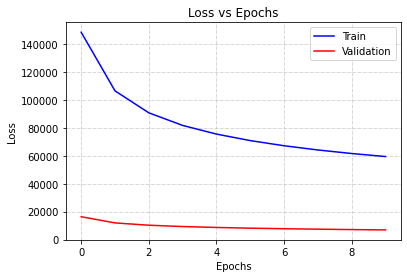

In [78]:
# Plot changes in loss
plt.plot(tl, c = 'b', label = 'Train')
plt.plot(vl, c = 'r', label = 'Validation')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(linestyle='-.', linewidth=0.5)
plt.legend()
plt.show()

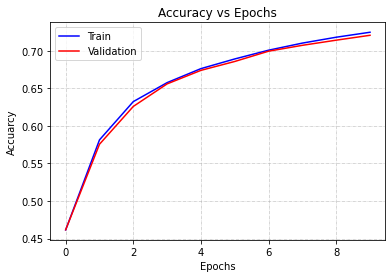

In [79]:
# Plot changes in accuracy
plt.plot(ta, c = 'b', label = 'Train')
plt.plot(va, c = 'r', label = 'Validation')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuarcy')
plt.grid(linestyle='-.', linewidth=0.5)
plt.legend()
plt.show()